## Response to reviewer #2

This notebook has relevant plots and pieces of information to clarify the comments of reviewer 2:

1. What happens at the bottom of the pool? (Is there heavy water over light water?)
2. Is GMREDI changing the prescribed values of diffusivity near the bottom?
5. How important is recirculation through the boundaries?
5. How might results change if a more realistic profile was used? (Nitrate or real salinity)


In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr

import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import warnings
warnings.filterwarnings('ignore')

In [2]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be a vector (1D)
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[:]) + beta*(S[:]))
    return rho



def call_rho(t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 


### 1. What happens at the bottom of the pool? (Is there heavy water over light water?)

From the [[documentation|http://mitgcm.org/sealion/online_documents/node145.html]]

*Two options are available to parameterize ocean convection: one is to use the convective adjustment scheme. In this case, you need to set the variable cadjFreq, which represents the frequency (in s) with which the adjustment algorithm is called, to a non-zero value (if set to a negative value by the user, the model will set it to the tracer time step). The other option is to parameterize convection with implicit vertical diffusion. To do this, set the logical variable implicitDiffusion to '.TRUE.' and the real variable ivdc_kappa to a value (in m$ ^{2}$/s) you wish the tracer vertical diffusivities to have when mixing tracers vertically due to static instabilities. Note that cadjFreq and ivdc_kappa can not both have non-zero value.*

#### Implementation

I have the second option working in my configuration. Convection is parametrized by setting  the vertical diffusivity of the tracer to be ``ivdc_kappa=10`` m$^2$s$^{-1}$ when tracers are mixed due to static instabilities. 

This is between $10^6$ to $10^3$ times higher that the prescribed vertical diffusivity...


So if I have, I wouldn't see it. The following shows profiles of density at different locations of the pool for uniform and enhanced diffusivity cases.


In [3]:
# seaborn controls
sns.set_context('notebook')
sns.set_style('white')

# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

state_file_kv = '/data/kramosmu/results/TracerExperiments/3DVISC/run05/stateGlob.nc' 
state_kv = xr.open_dataset(state_file)

ptracers_file_kv = '/data/kramosmu/results/TracerExperiments/3DVISC/run05/ptracersGlob.nc'
ptracers_kv = xr.open_dataset(ptracers_file)

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [4]:
hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

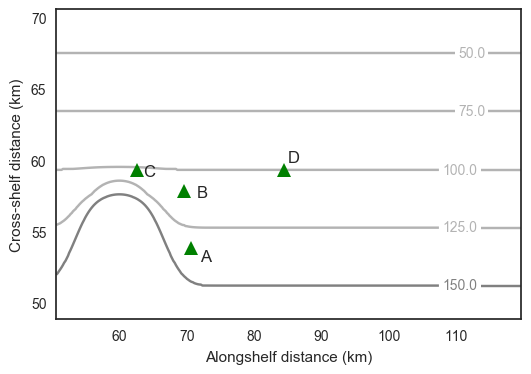

In [5]:
fig,ax = plt.subplots(1,1, figsize=(6,4))

yslice_bac = slice(210,310)
xslice_bac = slice(120,360)

cs = ax.contour(grid.X[xslice_bac]/1E3,grid.Y[yslice_bac]/1E3,grid.Depth[yslice_bac,xslice_bac], 
                [50, 75, 100, 125, 150],
                colors=['0.7','0.7','0.7','0.7','0.5'] )
plt.clabel(cs, inline=1, fontsize=10, fmt='%0.1f', inline_spacing=0)
ax.set_xlabel('Alongshelf distance (km)')
ax.set_ylabel('Cross-shelf distance (km)')

x_sts = [245, 240, 200, 290]
y_sts = [240, 260, 267, 267]
ax.plot(grid.X[x_sts]/1E3, grid.Y[y_sts]/1E3, '^g', ms=10)
ax.text(72,53,'A')
ax.text(71.5,57.5,'B')
ax.text(63.5,59,'C')
ax.text(85,60,'D')



Stations at which I will look at density profiles (triangles). Depth contours in m. The shelf break represented by 150 m isobath.

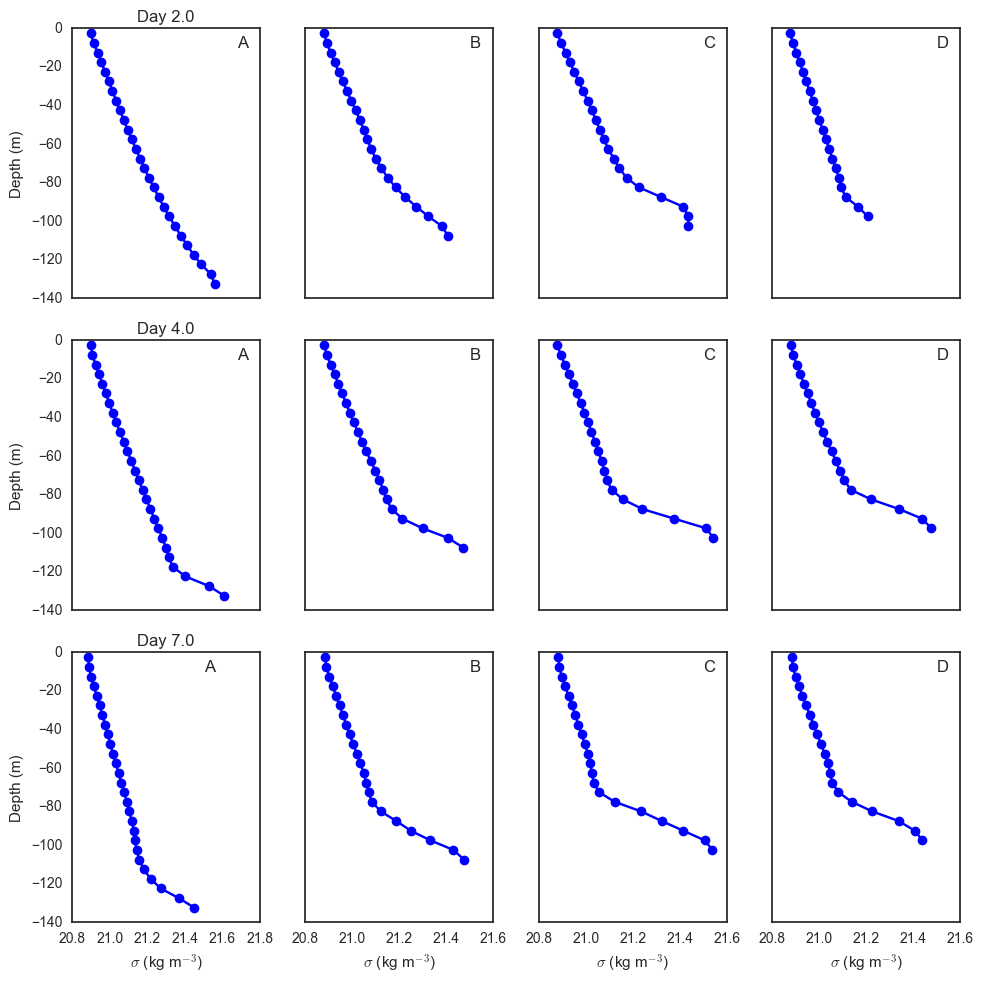

In [6]:
fig,ax = plt.subplots(3,4, figsize=(10,10), sharex= True, sharey = True)
st_code = ['A','B','C','D']

t = 4 # day 2
for axs, xind, yind, st in zip(ax[0,:], x_sts, y_sts, st_code):  
    rho = call_rho(t,yind, xind)
    axs.plot(np.ma.masked_array(rho,mask = MaskC[:,yind,xind])-RhoRef,grid.RC, 'bo-')
    axs.text(21.5,-10,st)
    ax[0,0].set_title('Day %0.1f' %(t/2))

t = 8 # day 4
for axs, xind, yind, st in zip(ax[1,:], x_sts, y_sts, st_code):  
    rho = call_rho(t,yind, xind)
    axs.plot(np.ma.masked_array(rho,mask = MaskC[:,yind,xind])-RhoRef,grid.RC, 'bo-')
    axs.text(21.5,-10,st)
    ax[1,0].set_title('Day %0.1f' %(t/2))

t = 14 # day 7
for axs, xind, yind, st in zip(ax[2,:], x_sts, y_sts, st_code):  
    rho = call_rho(t,yind, xind)
    axs.plot(np.ma.masked_array(rho,mask = MaskC[:,yind,xind])-RhoRef,grid.RC, 'bo-')
    axs.text(21.5,-10,st)
    ax[2,0].set_title('Day %0.1f' %(t/2))

ax[0,0].set_ylabel('Depth (m)')
ax[1,0].set_ylabel('Depth (m)')
ax[2,0].set_ylabel('Depth (m)')
ax[2,0].set_xlabel(r'$\sigma$ (kg m$^{-3}$)')
ax[2,1].set_xlabel(r'$\sigma$ (kg m$^{-3}$)')
ax[2,2].set_xlabel(r'$\sigma$ (kg m$^{-3}$)')
ax[2,3].set_xlabel(r'$\sigma$ (kg m$^{-3}$)')
ax[2,0].set_xticks([20.8,21.0,21.2,21.4,21.6,21.8])


plt.tight_layout()
    

 We chose 4 stations, 3 around the canyon rim and one farther into the downstream shelf and all of them show a stable density profiles during the time dependent phase (day 2) and the advective phase (days 4 and 7). The closest to an unstable profile occurs at station C (near head) during day 2.

### Exploring the counter for IVDC

In [7]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

convadj_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_DIAG_IVDC/run01/convadjGlob.nc'
ivdc = xr.open_dataset(convadj_file)


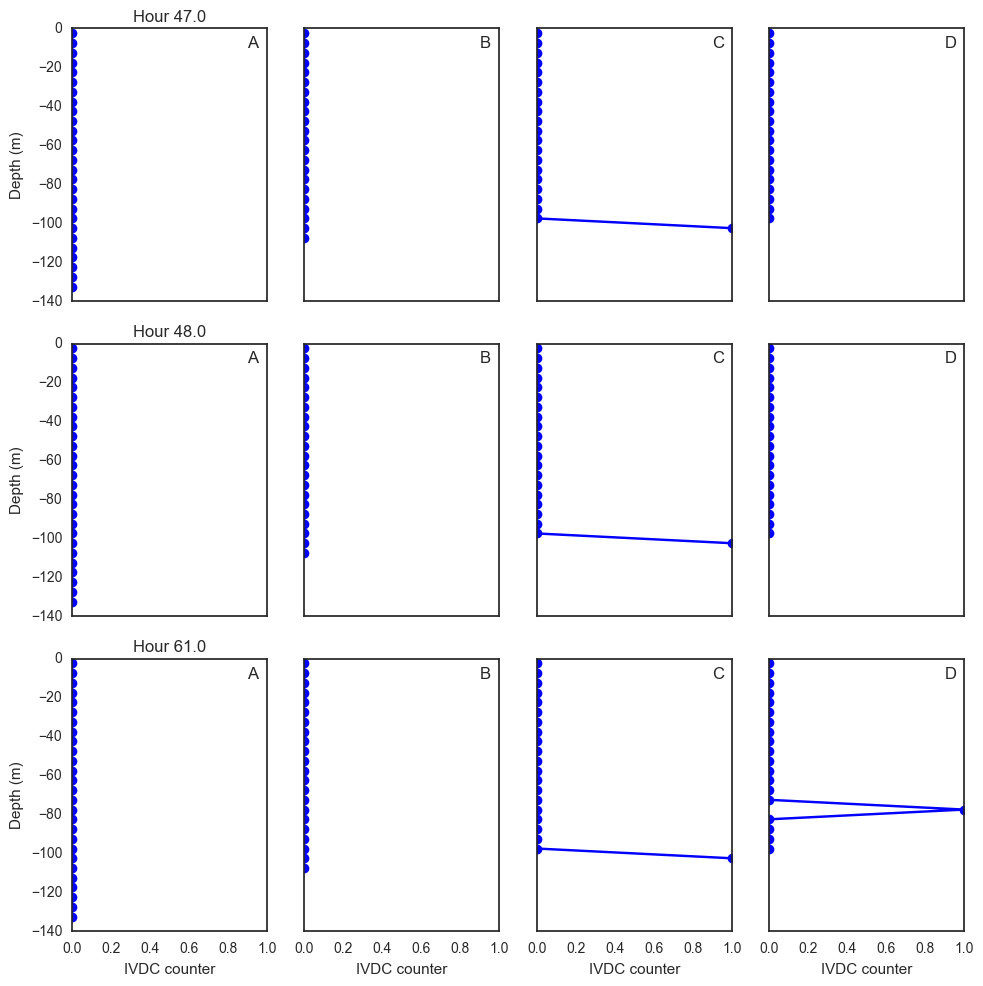

In [85]:
fig,ax = plt.subplots(3,4, figsize=(10,10), sharex= True, sharey = True)
st_code = ['A','B','C','D']

t = 47 # day 2
for axs, xind, yind, st in zip(ax[0,:], x_sts, y_sts, st_code):  
    axs.plot(np.ma.masked_array(ivdc.CONVADJ[t,:,yind,xind],mask = MaskC[:40,yind,xind]),grid.RC[:40], 'bo-')
    axs.text(0.9,-10,st)
    ax[0,0].set_title('Hour %0.1f' %(t))

t = 48 # day 4
for axs, xind, yind, st in zip(ax[1,:], x_sts, y_sts, st_code):  
    axs.plot(np.ma.masked_array(ivdc.CONVADJ[t,:,yind,xind],mask = MaskC[:40,yind,xind]),grid.RC[:40], 'bo-')
    axs.text(0.9,-10,st)
    ax[1,0].set_title('Hour %0.1f' %(t))

t = 61 # day 7
for axs, xind, yind, st in zip(ax[2,:], x_sts, y_sts, st_code):  
    axs.plot(np.ma.masked_array(ivdc.CONVADJ[t,:,yind,xind],mask = MaskC[:40,yind,xind]),grid.RC[:40], 'bo-')
    axs.text(0.9,-10,st)
    ax[2,0].set_title('Hour %0.1f' %(t))

ax[0,0].set_ylabel('Depth (m)')
ax[1,0].set_ylabel('Depth (m)')
ax[2,0].set_ylabel('Depth (m)')
ax[2,0].set_xlabel('IVDC counter')
ax[2,1].set_xlabel('IVDC counter')
ax[2,2].set_xlabel('IVDC counter')
ax[2,3].set_xlabel('IVDC counter')

plt.tight_layout()
    

In [ ]:
ind_tt = []
ind_kk = []
ind_jj = []
ind_ii = []

for tt in range(216):
    for ii in range(120,360):
        for jj in range(210,360):
            for kk in range(40):
                if ivdc.CONVADJ[tt,kk,jj,ii]>0.0:
                    ind_tt = ind_tt.append(tt)
                    ind_kk = ind_kk.append(kk)
                    ind_jj = ind_jj.append(jj)
                    ind_ii = ind_ii.append(ii)
    print(tt,kk,jj,ii)
                    
                


7

### 2.  Is GMREDI overwriting the imposed explicit diffusivity? What is the bottom boundary condition?

''*From reading the model description, it appears that values of viscosity and diffusivity are explicitly specified at each grid cell. This would mean that there is no increased turbulence in the bottom boundary layer. Is this true or does the GMREDI package compute mixing coefficeints based on the dynamics, which are then further enhaced in the canyon?*''

I am not resolving the bottom boundary layer (see notebook). As mentioned in the description of the configuration (line 139-141), we use a **quadratic drag law** with a coefficient of 0.002 for bottom stress by setting (see data file):

no_slip_sides = False

no_slip_bottom = False

bottomDragQuadratic = 0.002

For diffusivity, I am only using the REDI part of the scheme, this is, diffusing along and across isopycnals. In addition to the prescribed diffusivity, this scheme adds a tendency term to the tracer $\tau$ equation of the form $\nabla \cdot \kappa_{\rho}K_{Redi}\nabla \tau$ where $\kappa_{\rho}$ is the isopycnal diffusivity and $K_{Redi}$ is a rank 2 tensor that projects the gradient of $\tau$ onto the isopycnal surface. After using the small slope approximation ( typical isopycnal slopes in the ocean are order $10^{-4}$ and max of $10^{-2}$, so $|S|<<1$) the tensor is:

$$K_{Redi}=
  \begin{bmatrix}
    1 & 0 & S_x \\
    0 & 1 & S_y  \\
    S_x & S_y & |S|^2
  \end{bmatrix},
$$
where $S_x=-\partial_x\sigma/\partial_z\sigma$ and $S_y=-\partial_y\sigma/\partial_z\sigma$ are the components of the isopycnal slope.

Hence, the Redi scheme is adding more diffusivity where isopycnals are most tilted. One of the regions where isopycnals are most tilted is within the canyon. The REDi scheme is only working on tracers (T, S, passive tracer), so it is not explicitly adding to the viscosity.


The ''effective'' vertical diffusivity that the tracer ''feels'' is determined by the prescribed diffusivity, the tilting of isopycnals via the Redi scheme and the diffusivity due to the advective scheme.

We can diagnose the effect of diffusivity by looking at the vertical diffusive flux of the passive tracer:

Total diffusive vertical flux = Expl + Impl = (GMREDI leakage into vertical) + (numerical (adv. scheme)+ diffusivity + GMREDI)

Expl has the leaked diffusivity from GMREDI into the vertical (the larger the isopycnal tilting, the larger Expl will be). It is negative because it is a correction to Impl. Impl is the implicit calculation of diffusivity plus the numerical diffusivity from the advection scheme plus GMREDI vertical contribution.

Get a clear picture from this notebook: transport/maps_vertical_diffusive_flux_components_NOREDI.ipynb


In [5]:
## Set paths ##
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'

# Base case (kv=1E-5, N=5.5E-3, f=9.66E-5)
flux_file38 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/FluxTR01Glob.nc'  
# high kv canyon (1E-3 m^2s^-1)
flux_file3D06 = '/data/kramosmu/results/TracerExperiments/3DVISC/run06/FluxTR01Glob.nc'
# Base case without GMREDI
flux_file01 = '/data/kramosmu/results/TracerExperiments/NOGMREDI/run01/FluxTR01Glob.nc' 

## open datasets ##
grid = xr.open_dataset(grid_file)
flux38 = xr.open_dataset(flux_file38)
flux3D06 = xr.open_dataset(flux_file3D06)
flux01 = xr.open_dataset(flux_file01)

# Variable names
varn = {'expDF':'DFrETr01', 'impDF':'DFrITr01','advF':'ADVrTr01'}


OSError: No such file or directory

In [ ]:
def make_fig_kv(tt,zz,cmap='spectral',xslice=slice(0,360),yslice=slice(0,360)):    
    
    # Set figure and axis
    fig, ax = plt.subplots(3, 3, figsize=(16,12), sharex=True, sharey=True)

    # Find mask from open cell fractions
    Mask = np.ma.masked_equal(grid.HFacC.isel(Z=zz),0)
    
    # Select what to plot
    flux_I_38 = np.ma.masked_array(flux38.DFrITr01.isel(T=tt,Zld000090=zz,X=xslice,Y=yslice).data/ \
                                   grid.rA.isel(X=xslice,Y=yslice),
                                   mask=Mask[yslice,xslice].mask)
    
    flux_I_3D06 = np.ma.masked_array(flux3D06.DFrITr01.isel(T=tt,Zld000090=zz,X=xslice,Y=yslice).data/ \
                                   grid.rA.isel(X=xslice,Y=yslice),
                                   mask=Mask[yslice,xslice].mask)
    
    flux_I_01 = np.ma.masked_array(flux01.DFrITr01.isel(T=tt,Zld000090=zz,X=xslice,Y=yslice).data/ \
                                   grid.rA.isel(X=xslice,Y=yslice),
                                   mask=Mask[yslice,xslice].mask)

    flux_E_38 = np.ma.masked_array(flux38.DFrETr01.isel(T=tt,Zld000090=zz,X=xslice,Y=yslice).data/ \
                                   grid.rA.isel(X=xslice,Y=yslice),
                                   mask=Mask[yslice,xslice].mask)
    
    flux_E_3D06 = np.ma.masked_array(flux3D06.DFrETr01.isel(T=tt,Zld000090=zz,X=xslice,Y=yslice).data/ \
                                   grid.rA.isel(X=xslice,Y=yslice),
                                   mask=Mask[yslice,xslice].mask)
    
    flux_E_01 = np.ma.masked_array(flux01.DFrETr01.isel(T=tt,Zld000090=zz,X=xslice,Y=yslice).data/ \
                                   grid.rA.isel(X=xslice,Y=yslice),
                                   mask=Mask[yslice,xslice].mask)

    ## Define colormap limits
    cmaxT = (flux_E_38 + flux_I_38).max()
    cminT = (flux_E_38 + flux_I_38).min()

    # Plot
    cnf1 = ax[0,0].contourf(grid.X.isel(X=xslice),grid.Y.isel(Y=yslice),flux_I_38,
                            20,
                            cmap='spectral',
                            )
    cb1 = plt.colorbar(cnf1,ax=ax[0,0])
    ax[1,0].set_title('DFr Implicit, base case , day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
#------------
    cnf2 = ax[1,0].contourf(grid.X.isel(X=xslice),grid.Y.isel(Y=yslice),flux_I_3D06,
                            20,
                            cmap='spectral',
                            )
    cb2 = plt.colorbar(cnf2,ax=ax[1,0])
    ax[1,0].set_title('DFr Implicit, Canyon enhanced $\kappa_v$ , day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
#------------
    cnf3 = ax[2,0].contourf(grid.X.isel(X=xslice) ,grid.Y.isel(Y=yslice) ,flux_I_01,
                            20,
                            cmap='spectral',
                            )
    cb3 = plt.colorbar(cnf2,ax=ax[2,0])
    ax[2,0].set_title('DFr Implicit, NO GMREDI, day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
#------------
    cnf4 = ax[0,1].contourf(grid.X.isel(X=xslice) ,grid.Y.isel(Y=yslice) ,flux_E_38,
                            20,
                            cmap='spectral',
                           )
    cb4 = plt.colorbar(cnf4,ax=ax[0,1])
    ax[0,1].set_title('DFr Explict, Base Case, day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
#------------
    cnf5 = ax[1,1].contourf(grid.X.isel(X=xslice) ,grid.Y.isel(Y=yslice) ,flux_E_3D06,
                            20,
                            cmap='spectral',
                           )
    cb5 = plt.colorbar(cnf5,ax=ax[1,1])
    ax[1,1].set_title('DFr Explict, Base case canyon enhaced $\kappa_v$, day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
#------------

    cnf6 = ax[2,1].contourf(grid.X.isel(X=xslice) ,grid.Y.isel(Y=yslice) ,flux_E_01,
                            20,
                            cmap='spectral',
                           )
    cb6 = plt.colorbar(cnf6,ax=ax[2,1])
    ax[2,1].set_title('DFr Explict, NO GMREDI, day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
#------------
    
    cnf7 = ax[0,2].contourf(grid.X.isel(X=xslice) ,grid.Y.isel(Y=yslice) ,flux_E_38+flux_I_38,
                            20,
                            cmap='spectral',
                           )
    cb7 = plt.colorbar(cnf7,ax=ax[0,2])
    ax[0,2].set_title('DF Total, Base Case, day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
#------------

    cnf8 = ax[1,2].contourf(grid.X.isel(X=xslice) ,grid.Y.isel(Y=yslice) ,flux_E_3D06+flux_I_3D06,
                            20,
                            cmap='spectral',
                            )
    cb8 = plt.colorbar(cnf8,ax=ax[1,2])
    ax[1,2].set_title('DF Total, canyon enhaced $\kappa_v$, day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
#------------
    cnf9 = ax[2,2].contourf(grid.X.isel(X=xslice) ,grid.Y.isel(Y=yslice) ,flux_E_01+flux_I_01,
                            20,
                            cmap='spectral',
                            )
    cb9 = plt.colorbar(cnf9,ax=ax[2,2])
    ax[2,2].set_title('DF Total, NO GMREDI, day %1.1f, depth %1.1f' %((tt/2.0)+0.5, grid.Z[zz]))
    
    for axs in [ax[0,0],ax[1,0],ax[2,0]]:
        axs.set_ylabel('Cross-shore distance (m)')
    
    for axs in [ax[2,0],ax[2,1],ax[2,2]]:
        axs.set_xlabel('Alongshore distance (m)')
    
    for axs in [ax[0,0],ax[1,0],ax[2,0],ax[0,1],ax[1,1],ax[2,1],ax[0,2],ax[1,2],ax[2,2]]:
        axs.contour(grid.X.isel(X=xslice),grid.Y.isel(Y=yslice),grid.Depth.isel(X=xslice,Y=yslice),[152.5,1000], colors='0.4')
    
    for cbax in [cb7,cb8,cb9]:
        cbax.set_label('$[C]ms^{-1}$')
    
    plt.tight_layout()

### 5. Recirculation through periodic boundaries

Dinniman and Klinck - According to that papaer it is hard to get open boundaries correct. Main difference between open and periodic bdy is that strong flow variability develops in periodic case (due to energy trapped in the model that degrades the solution). 

After 12 days, at 150 m, MO presents slower flow over abyss and periodic presents strongest everywhere.

Look at advection timescale, baroclinic waves, shelf waves, vorticity


In [5]:
max_U = 0.35 #ms^{-1} exaggerating a bit, this is the velocity of the incoming flow.
half_distance = 120000 # m recirculation distance alongshore

cycle_time = half_distance/max_U

print('Time to go around the domain (advection) is %1.1f hr or %1.1f days' %(cycle_time/(3600),cycle_time/(24*3600)))



Time to go around the domain (advection) is 95.2 hr or 4.0 days


In [22]:
# Speed of 1st baroclinic mode c_n=(gD_n)^{1/2} where D_n = (N^1/2 D^1/2) / (g n^2 Pi^2), n=1
g = 9.81
n = 1
N = 5.5E-3

#For D = 150 m
D = 150
Dn = (((N)**2))*(D**2)/(g*(np.pi**2))
cn = np.sqrt(g*(Dn))
print('For D=150 m , Dn = %1.2f m, cn=%1.2f m/s' %(Dn,cn))

#For D = 1200 m
D = 1200
Dn = (((N)**2))*(D**2)/(g*(np.pi**2))
cn = np.sqrt(g*(Dn))
print('For D=1200 m , Dn = %1.2f m, cn=%1.2f m/s' %(Dn,cn))

For D=150 m , Dn = 0.01 m, cn=0.26 m/s
For D=1200 m , Dn = 0.45 m, cn=2.10 m/s


In [23]:
# Speed of 2nd baroclinic mode c_n=(gD_n)^{1/2} where D_n = (N^1/2 D^1/2) / (g n^2 Pi^2), n=2
g = 9.81
n = 2
N = 5.5E-3

#For D = 150 m
D = 150
Dn = (((N)**2)*(D**2))/(g*(np.pi**2)*(n**2))
cn = np.sqrt(g*(Dn))
print('For D=150 m , Dn = %1.2f m, cn=%1.2f m/s' %(Dn,cn))

#For D = 1200 m
D = 1200
Dn = (((N)**2)*(D**2))/(g*(np.pi**2)*(n**2))
cn = np.sqrt(g*(Dn))
print('For D=1200 m , Dn = %1.2f m, cn=%1.2f m/s' %(Dn,cn))

For D=150 m , Dn = 0.00 m, cn=0.13 m/s
For D=1200 m , Dn = 0.11 m, cn=1.05 m/s


The pool re enters on the upstream side but it is outside the domain I am considering when I do the BAC average.

### 6. Discuss how would the results change for a more realistic tracer profile.